In [2]:
# Libraries
import pandas as pd
import shapely.ops

from GTFSDelay import GTFSDelay
import geopandas as gpd
import seaborn as sns
import partridge as ptg
from shapely.ops import nearest_points, split, substring
from shapely.geometry import Point, MultiPoint, LineString


In [4]:
path = 'D:/PyCharm/Projects/GTFS_Delay/data/gtfs.zip'
#service_ids = ptg.read_busiest_date(path)[1]
view = {'trips.txt': {}}
test_data = ptg.load_geo_feed(path, view)
shapes = test_data.shapes

D:\Anaconda\envs\GTFS_Delay\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [5]:
shapes.iloc[0, :]

shape_id                                                25648
geometry    LINESTRING (-123.0873313 44.0577683, -123.0870...
Name: 0, dtype: object

In [6]:
test_view = {'trips.txt': {'shape_id': shapes.iloc[0,:].iloc[0]}}
test_data = ptg.load_geo_feed(path, test_view)
test_data

In [24]:
test_data.stops['snapped_geom'] = [nearest_points(test_data.shapes['geometry'], x)[0][0]
                                           for x in test_data.stops['geometry']]

test_data.stops['lin_ref_pos1'] = 0.0
for i in range(len(test_data.stops)):
    test_data.stops.iloc[i, 13] = shapely.line_locate_point(test_data.shapes['geometry'][0],
                                                            test_data.stops['geometry'].iloc[i],
                                                            normalized=True)

D:\Anaconda\envs\GTFS_Delay\Lib\site-packages\shapely\linear.py:86: RuntimeWarning: invalid value encountered in line_locate_point_normalized
  return lib.line_locate_point_normalized(line, other)


In [128]:
# Create segments

stops = test_data.stops.sort_values(by='lin_ref_pos', axis=0, ascending=True, ignore_index=True)

# Generate stop pairs
stop_pairs = pd.DataFrame(columns=['name', 'start_stop', 'end_stop', 'lin_ref_pos_start', 'lin_ref_pos_end'])
for i in range(len(stops) - 1):
    start = stops['stop_id'].iloc[i]
    end = stops['stop_id'].iloc[i+1]
    name = str(start) + '-' + str(end)
    stop_pairs = pd.concat([stop_pairs,
                            pd.DataFrame({'name': name,
                                          'start_stop': start,
                                          'end_stop': end,
                                          'lin_ref_pos_start': stops['lin_ref_pos'].iloc[i],
                                          'lin_ref_pos_end': stops['lin_ref_pos'].iloc[i+1]},
                                         index=[0])], 
                           ignore_index=True)
    
# Create line segment for each stop pair
stop_pairs['seg_geom'] = stop_pairs[['lin_ref_pos_start', 'lin_ref_pos_end']].\
    apply(lambda x: substring(test_data.shapes['geometry'].iloc[0], x[0], x[1],normalized=True), axis=1)

# Make GeoDataFrame
stop_pairs = gpd.GeoDataFrame(data=stop_pairs, geometry='seg_geom', crs='EPSG:4326')

# Calculate distance in miles
stop_pairs['seg_distance'] = stop_pairs.to_crs(epsg=6561)['seg_geom'].apply(lambda x: shapely.length(x)) / 5280 

C:\Users\TheMachine\AppData\Local\Temp\ipykernel_17160\2759201861.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  stop_pairs = pd.concat([stop_pairs,
C:\Users\TheMachine\AppData\Local\Temp\ipykernel_17160\2759201861.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  apply(lambda x: substring(test_data.shapes['geometry'].iloc[0], x[0], x[1],normalized=True), axis=1)


In [129]:
stop_pairs

,name,start_stop,end_stop,lin_ref_pos_start,lin_ref_pos_end,seg_geom,seg_distance
0,01060-01061,01060,01061,0.004326,0.167906,"LINESTRING (-123.08725 44.05775, -123.08707 44...",0.169165
1,01061-01062,01061,01062,0.167906,0.298311,"LINESTRING (-123.08795 44.05648, -123.08818 44...",0.130432
2,01062-01063,01062,01063,0.298311,0.368028,"LINESTRING (-123.08970 44.05587, -123.08970 44...",0.086523
3,01063-01058,01063,01058,0.368028,0.509623,"LINESTRING (-123.08970 44.05463, -123.08968 44...",0.132470
4,01058-02126,01058,02126,0.509623,0.776212,"LINESTRING (-123.09201 44.05440, -123.09232 44...",0.290500
5,02126-escenter,02126,escenter,0.776212,0.984898,"LINESTRING (-123.09432 44.05173, -123.09426 44...",0.252262


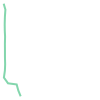

In [108]:
stop_pairs['seg_geom'].iloc[5]

In [8]:
testobj = GTFSDelay(test_data)

D:\Anaconda\envs\GTFS_Delay\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
D:\Anaconda\envs\GTFS_Delay\Lib\site-packages\shapely\linear.py:86: RuntimeWarning: invalid value encountered in line_locate_point_normalized
  return lib.line_locate_point_normalized(line, other)
D:\PyCharm\Projects\GTFS_Delay\GTFSDelay.py:49: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.stop_pairs = pd.concat([self.stop_pairs,
D:\PyCharm\Projects\

In [10]:
testobj.gtfs.stop_times

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,layover,pattern_id,pickup_type,drop_off_type,shape_dist_traveled,timepoint
0,702365,34680.0,34680.0,01060,1,01 EUGENE STATION,True,25648,NaN,NaN,NaN,1
1,702365,NaN,NaN,01061,2,01 EUGENE STATION,False,25648,NaN,NaN,NaN,0
2,702365,NaN,NaN,01062,3,01 EUGENE STATION,False,25648,NaN,NaN,NaN,0
3,702365,34860.0,34860.0,01063,4,01 EUGENE STATION,False,25648,NaN,NaN,NaN,1
4,702365,NaN,NaN,01058,5,01 EUGENE STATION,False,25648,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...
205,705297,NaN,NaN,01062,3,01 EUGENE STATION,False,25648,NaN,NaN,NaN,0
206,705297,49260.0,49260.0,01063,4,01 EUGENE STATION,False,25648,NaN,NaN,NaN,1
207,705297,NaN,NaN,01058,5,01 EUGENE STATION,False,25648,NaN,NaN,NaN,0
208,705297,NaN,NaN,02126,6,01 EUGENE STATION,False,25648,NaN,NaN,NaN,0
